<a href="https://colab.research.google.com/github/daveAnalyst/zindi-mhp-energy-prediction-2025/blob/master/zindi_mhp_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zindi Micro-Hydropower Energy Load Prediction

This notebook aims to predict daily energy consumption (kWh) per data user for Micro-Hydropower Plants (MHPs) in Kalam, Pakistan. We will use MHP sensor data and climate indicators to build a predictive model.

**Objective:** Forecast total daily kWh per user for one month into the future.
**Metric:** Root Mean Squared Error (RMSE).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -r requirements.txt
# Or if requirements.txt is missing/outdated, install key ones:
!pip install pandas openpyxl lightgbm matplotlib seaborn --upgrade

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [3]:
import os
import zipfile
import shutil

# Define path to data on Google Drive (adjust if your folder structure differs)
DRIVE_DATA_PATH = '/content/drive/MyDrive/Zindi MHP Challenge/data'

# Define path for data within Colab's runtime storage
COLAB_DATA_PATH = '/content/data' # This is temporary storage

# Create the target directory in Colab
os.makedirs(COLAB_DATA_PATH, exist_ok=True)

print("Unzipping Data.zip...")
try:
    with zipfile.ZipFile(os.path.join(DRIVE_DATA_PATH, 'Data.zip'), 'r') as zip_ref:
        zip_ref.extractall(COLAB_DATA_PATH)
    print("Data.zip unzipped.")
except FileNotFoundError:
    print(f"ERROR: Data.zip not found at {os.path.join(DRIVE_DATA_PATH, 'Data.zip')}")

print("\nUnzipping Climate Data.zip...")
try:
    # Assuming Climate Data.zip contains the .xlsx file, maybe inside a folder
    with zipfile.ZipFile(os.path.join(DRIVE_DATA_PATH, 'Climate Data.zip'), 'r') as zip_ref:
        zip_ref.extractall(COLAB_DATA_PATH) # Extract directly into /content/data
    print("Climate Data.zip unzipped. Check contents:")
    !ls -R {COLAB_DATA_PATH} # List contents recursively to find the .xlsx file
    # You might need to move the .xlsx file out of a subfolder if one was created
    !mv "{COLAB_DATA_PATH}/Climate Data/Kalam Climate Data.xlsx" "{COLAB_DATA_PATH}/"

except FileNotFoundError:
    print(f"ERROR: Climate Data.zip not found at {os.path.join(DRIVE_DATA_PATH, 'Climate Data.zip')}")

print("\nCopying SampleSubmission.csv...")
try:
    shutil.copy(os.path.join(DRIVE_DATA_PATH, 'SampleSubmission.csv'), COLAB_DATA_PATH)
    print("SampleSubmission.csv copied.")
except FileNotFoundError:
     print(f"ERROR: SampleSubmission.csv not found at {os.path.join(DRIVE_DATA_PATH, 'SampleSubmission.csv')}")

print("\nFinal contents of Colab data directory:")
!ls {COLAB_DATA_PATH}

# IMPORTANT: Set DATA_DIR for the rest of the notebook to use this Colab path
DATA_DIR_FOR_NOTEBOOK = COLAB_DATA_PATH

Unzipping Data.zip...
Data.zip unzipped.

Unzipping Climate Data.zip...
Climate Data.zip unzipped. Check contents:
/content/data:
'Climate Data'	 Data.csv   __MACOSX

'/content/data/Climate Data':
'Correlation Matrix.png'   'snow with MHPs.jpg'
'Kalam Climate Data.xlsx'  'temperature with MHPs.jpg'

/content/data/__MACOSX:

Copying SampleSubmission.csv...
SampleSubmission.csv copied.

Final contents of Colab data directory:
'Climate Data'	 Data.csv  'Kalam Climate Data.xlsx'   __MACOSX   SampleSubmission.csv


In [9]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math # For sqrt
import os

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Settings
SEED = 42
np.random.seed(SEED)
DATA_DIR = 'data' # Set the path to your data directory

# Ensure plots are displayed inline and set a style
%matplotlib inline
# Use a style that's likely available - adjust if needed
plt.style.use('seaborn-v0_8-darkgrid')
# If the above fails, try: plt.style.use('seaborn-darkgrid') or plt.style.use('ggplot')

print("Libraries imported and settings configured.")
print(f"Data directory set to: {DATA_DIR}")
print(f"Available plotting styles: {plt.style.available}") # Optional: see available styles

Libraries imported and settings configured.
Data directory set to: data
Available plotting styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [1]:
import os

# ---- IMPORTANT: SET THIS CORRECTLY ----
# Option 1: If you unzipped/copied data to Colab runtime storage
DATA_DIR = '/content/data'
# Option 2: If you are reading directly from Google Drive (potentially slower)
# DATA_DIR = '/content/drive/MyDrive/Zindi MHP Challenge/data' # Adjust path if needed
# --------------------------------------

print(f"Using DATA_DIR: {DATA_DIR}")

# Check 1: Does DATA_DIR exist?
print(f"\nChecking existence of DATA_DIR...")
if not os.path.exists(DATA_DIR):
    print(f"--- ERROR ---: Directory '{DATA_DIR}' does NOT exist!")
    print("Action: Ensure you have run the Drive mount AND the data unzipping/copying cell correctly in this session.")
else:
    print(f"Directory '{DATA_DIR}' exists.")

    # Check 2: List files in DATA_DIR (Check names and capitalization!)
    print(f"\nFiles present in '{DATA_DIR}':")
    !ls -lh "{DATA_DIR}" # Use shell command for clear listing

    # Check 3: Verify specific expected files
    expected_files = ['Data.csv', 'Kalam Climate Data.xlsx', 'SampleSubmission.csv']
    print("\nChecking for expected files:")
    all_found = True
    for f_name in expected_files:
        f_path = os.path.join(DATA_DIR, f_name)
        if os.path.exists(f_path):
            print(f"  [ OK ] Found: {f_name}")
        else:
            print(f"  [FAIL] MISSING: {f_name} at path {f_path}")
            all_found = False
    if not all_found:
        print("--- ERROR ---: One or more required data files are missing from DATA_DIR.")
        print("Action: Re-run the data unzipping/copying cell, checking its output for errors.")
    else:
        print("All expected files seem to be present.")

# Check 4: Ensure openpyxl is installed (relevant for Excel)
print("\nChecking for openpyxl installation...")
try:
    import openpyxl
    print("  [ OK ] openpyxl is installed.")
except ImportError:
    print("  [FAIL] openpyxl is NOT installed.")
    print("Action: Run '!pip install openpyxl' in a cell.")

Using DATA_DIR: /content/data

Checking existence of DATA_DIR...
Directory '/content/data' exists.

Files present in '/content/data':
total 2.8G
drwxr-xr-x 2 root root 4.0K Apr  5 14:48 'Climate Data'
-rw-r--r-- 1 root root 2.8G Apr  5 14:48  Data.csv
-rw-r--r-- 1 root root 735K Apr  5 14:48 'Kalam Climate Data.xlsx'
drwxr-xr-x 2 root root 4.0K Apr  5 14:48  __MACOSX
-rw------- 1 root root 260K Apr  5 14:48  SampleSubmission.csv

Checking for expected files:
  [ OK ] Found: Data.csv
  [ OK ] Found: Kalam Climate Data.xlsx
  [ OK ] Found: SampleSubmission.csv
All expected files seem to be present.

Checking for openpyxl installation...
  [ OK ] openpyxl is installed.


In [2]:
import pandas as pd
import os

# --- Use the SAME DATA_DIR as verified in Step 1 ---
DATA_DIR = '/content/data' # Or your Drive path
# ----------------------------------------------------

print("--- Verifying Column Names ---")

# Check CSV Columns
try:
    print("\nChecking Data.csv headers...")
    csv_path = os.path.join(DATA_DIR, 'Data.csv')
    # Load only 5 rows, use engine='python' if C engine failed before
    csv_head = pd.read_csv(csv_path, nrows=5, engine='python')
    print(f"Columns found in Data.csv: {csv_head.columns.tolist()}")
    # --->>> CONFIRM: Are 'date_time' and 'Source' exactly as expected? <<<---
except Exception as e:
    print(f"ERROR reading Data.csv header: {e}")

# Check Excel Columns
try:
    print("\nChecking Kalam Climate Data.xlsx headers...")
    excel_path = os.path.join(DATA_DIR, 'Kalam Climate Data.xlsx')
    excel_head = pd.read_excel(excel_path, nrows=5) # Reads first sheet by default
    print(f"Columns found in Kalam Climate Data.xlsx: {excel_head.columns.tolist()}")
    # --->>> CONFIRM: Is 'Date_Time' exactly as expected? <<<---
    # Let's also see the format of the date column
    date_col_name = 'Date_Time' # Use the actual column name found
    if date_col_name in excel_head.columns:
         print(f"Sample values in Excel column '{date_col_name}':")
         print(excel_head[date_col_name].head())
    else:
         print(f"Warning: Column '{date_col_name}' not found in Excel header check.")

except Exception as e:
    print(f"ERROR reading Kalam Climate Data.xlsx header: {e}")

--- Verifying Column Names ---

Checking Data.csv headers...
Columns found in Data.csv: ['date_time', 'v_red', 'current', 'power_factor', 'kwh', 'Source', 'v_blue', 'v_yellow', 'consumer_device_9', 'consumer_device_x']

Checking Kalam Climate Data.xlsx headers...
Columns found in Kalam Climate Data.xlsx: ['Date Time', 'Temperature (°C)', 'Dewpoint Temperature (°C)', 'U Wind Component (m/s)', 'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)']


## 2. Load Data

Load the datasets:
1.  **MHP Data:** `Data.csv` contains the 5-minute interval sensor readings (voltage, current, kWh, etc.). We anticipate the timestamp column is named `date_time`.
2.  **Climate Data:** `Kalam Climate Data.xlsx` contains climate indicators (temperature, precipitation, etc.). This is an Excel file.
3.  **Sample Submission:** `SampleSubmission.csv` defines the required prediction format and IDs for the test set.

*Note: Reading Excel files requires the `openpyxl` library. Install it if needed (`pip install openpyxl`). Reading the MHP CSV might require `engine='python'` if the default C engine fails.*

In [1]:
# Cell 4: Load Data (Revised with Correct Column Names)

import pandas as pd
import numpy as np # Make sure numpy is imported
import os
import time

# --- Use the SAME DATA_DIR as verified previously ---
# Ensure this is set correctly for your Colab environment
DATA_DIR = '/content/data' # Or your Drive path: '/content/drive/MyDrive/Zindi MHP Challenge/data'
# ----------------------------------------------------

print("Loading data with verified column names...")
start_time = time.time()

try:
    # --- Load MHP Data (CSV) ---
    mhp_filename = 'Data.csv'
    mhp_path = os.path.join(DATA_DIR, mhp_filename)
    print(f"\n[{time.time() - start_time:.1f}s] Attempting to load MHP structure from: {mhp_path}")

    # Columns verified as correct in Data.csv
    mhp_cols_to_load = ['date_time', 'Source', 'kwh']
    print(f"Loading only columns: {mhp_cols_to_load}")

    mhp_data_raw = pd.read_csv(
        mhp_path,
        usecols=mhp_cols_to_load,
        #engine='python'  Keep if C engine failed
    )
    print(f"[{time.time() - start_time:.1f}s] Structure loaded for {mhp_filename}. Size: {mhp_data_raw.shape}")

    # Convert date column AFTER loading
    print(f"[{time.time() - start_time:.1f}s] Converting MHP date column ('date_time')...")
    mhp_data_raw['timestamp'] = pd.to_datetime(mhp_data_raw['date_time'], errors='coerce')
    if mhp_data_raw['timestamp'].isnull().any():
        print("Warning: Some MHP date conversions failed (resulted in NaT).")
    mhp_data_raw.drop(columns=['date_time'], inplace=True) # Drop original string column
    print(f"[{time.time() - start_time:.1f}s] MHP date converted.")

    # Rename user ID column (verified as 'Source')
    mhp_data_raw.rename(columns={'Source': 'user_id'}, inplace=True)
    print(f"[{time.time() - start_time:.1f}s] Loaded and initially processed: {mhp_filename}")


    # --- Load Climate Data (Excel) ---
    climate_filename = 'Kalam Climate Data.xlsx'
    climate_path = os.path.join(DATA_DIR, climate_filename)
    print(f"\n[{time.time() - start_time:.1f}s] Attempting to load Excel structure from: {climate_path}")
    # Load full Excel structure first, do not parse dates yet
    climate_data_raw = pd.read_excel(climate_path)
    print(f"[{time.time() - start_time:.1f}s] Structure loaded for {climate_filename}. Size: {climate_data_raw.shape}")
    print(f"Original Excel columns: {climate_data_raw.columns.tolist()}") # Show original names

    # --- Rename Excel Columns to Simpler Names ---
    # Use the EXACT names found in the verification step
    print(f"[{time.time() - start_time:.1f}s] Renaming Excel columns...")
    climate_rename_map = {
        'Date Time': 'date_time_excel', # Temporary name for date
        'Temperature (°C)': 'temperature',
        'Dewpoint Temperature (°C)': 'dew_point',
        'U Wind Component (m/s)': 'u_wind',
        'V Wind Component (m/s)': 'v_wind',
        'Total Precipitation (mm)': 'precipitation'
        # Add other columns here if needed later, e.g., 'Snowfall (mm)': 'snowfall'
    }
    # Check if all expected columns exist before renaming
    missing_cols = [col for col in climate_rename_map.keys() if col not in climate_data_raw.columns]
    if missing_cols:
         raise KeyError(f"Missing expected columns in Excel file: {missing_cols}")

    climate_data_raw.rename(columns=climate_rename_map, inplace=True)
    print(f"Columns after renaming: {climate_data_raw.columns.tolist()}")

    # --- Calculate Wind Speed Magnitude ---
    print(f"[{time.time() - start_time:.1f}s] Calculating wind speed magnitude...")
    climate_data_raw['wind_speed'] = np.sqrt(climate_data_raw['u_wind']**2 + climate_data_raw['v_wind']**2)
    # Drop original U/V components if no longer needed
    # climate_data_raw.drop(columns=['u_wind', 'v_wind'], inplace=True)
    print(f"Wind speed calculated.")

    # --- Convert Date Column AFTER Loading and Renaming ---
    print(f"[{time.time() - start_time:.1f}s] Converting Excel date column ('date_time_excel')...")
    climate_data_raw['timestamp'] = pd.to_datetime(climate_data_raw['date_time_excel'], errors='coerce')
    if climate_data_raw['timestamp'].isnull().any():
        print("Warning: Some Excel date conversions failed (resulted in NaT).")
    # Drop original date column AFTER successful conversion
    climate_data_raw.drop(columns=['date_time_excel'], inplace=True)
    print(f"[{time.time() - start_time:.1f}s] Excel date converted.")
    print(f"[{time.time() - start_time:.1f}s] Loaded and initially processed: {climate_filename}")


    # --- Load Sample Submission (CSV) ---
    sample_sub_filename = 'SampleSubmission.csv'
    sample_sub_path = os.path.join(DATA_DIR, sample_sub_filename)
    print(f"\n[{time.time() - start_time:.1f}s] Attempting to load sample submission from: {sample_sub_path}")
    sample_sub = pd.read_csv(sample_sub_path)
    print(f"[{time.time() - start_time:.1f}s] Successfully loaded: {sample_sub_filename}")

    total_time = time.time() - start_time
    print(f"\n[{total_time:.1f}s] All data loaded successfully.")

# --- Keep the SAME except blocks as before ---
except FileNotFoundError as e:
    print(f"\n--- ERROR: File Not Found ---")
    print(f"{e}")
    print(f"Please ensure files are directly in the '{DATA_DIR}' directory confirmed in Step 1.")
    raise
except ImportError as e:
     print(f"\n--- ERROR: Missing Library ---")
     print(f"{e}")
     print("Failed loading Excel file. Ensure openpyxl is installed (`!pip install openpyxl`).")
     raise
except ValueError as e:
    print(f"\n--- ERROR: Value Error during loading/parsing ---")
    print(f"{e}")
    print("This might be due to an incorrect column name during processing. Verify names from Step 2.")
    raise
except KeyError as e:
    print(f"\n--- ERROR: Key Error ---")
    print(f"{e}")
    print("This usually means a specified column name was not found during renaming or processing. Verify names from Step 2.")
    raise
except Exception as e:
     print(f"\n--- ERROR: An unexpected error occurred during data loading ---")
     print(f"{e}")
     raise

# --- Display Info (Optional but recommended) ---
# Select only the columns we will actually use going forward to keep info clean
mhp_final_cols = ['timestamp', 'user_id', 'kwh']
climate_final_cols = ['timestamp', 'temperature', 'dew_point', 'wind_speed', 'precipitation'] # Add others like 'snowfall' if needed

if 'mhp_data_raw' in locals():
    print("\n--- MHP Data Info (Post-Processing) ---")
    mhp_data_raw[mhp_final_cols].info() # Show info only for relevant columns
if 'climate_data_raw' in locals():
    print("\n--- Climate Data Info (Post-Processing) ---")
    climate_data_raw[climate_final_cols].info() # Show info only for relevant columns
if 'sample_sub' in locals():
    print("\n--- Sample Submission Head ---")
    print(sample_sub.head())

Loading data with verified column names...

[0.0s] Attempting to load MHP structure from: /content/data/Data.csv
Loading only columns: ['date_time', 'Source', 'kwh']
[66.5s] Structure loaded for Data.csv. Size: (39147559, 3)
[66.5s] Converting MHP date column ('date_time')...
[81.7s] MHP date converted.
[81.7s] Loaded and initially processed: Data.csv

[81.7s] Attempting to load Excel structure from: /content/data/Kalam Climate Data.xlsx
[83.8s] Structure loaded for Kalam Climate Data.xlsx. Size: (12228, 8)
Original Excel columns: ['Date Time', 'Temperature (°C)', 'Dewpoint Temperature (°C)', 'U Wind Component (m/s)', 'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)']
[83.8s] Renaming Excel columns...
Columns after renaming: ['date_time_excel', 'temperature', 'dew_point', 'u_wind', 'v_wind', 'precipitation', 'Snowfall (mm)', 'Snow Cover (%)']
[83.8s] Calculating wind speed magnitude...
Wind speed calculated.
[83.8s] Converting Excel date column ('d

## 3. Data Preprocessing and Aggregation

The MHP data is recorded at 5-minute intervals, but the prediction target is daily kWh per user. Climate data might also be at a finer granularity than daily.

We need to:
1.  Aggregate the MHP `kwh` readings to get the total daily sum for each `user_id`.
2.  Aggregate the climate data to daily statistics (e.g., mean temperature, total precipitation).
3.  Merge the aggregated daily MHP data with the aggregated daily climate data.
4.  Handle any missing values that might arise from the merge or exist in the original data.

In [5]:
# Cell 6: Data Preprocessing and Aggregation (Corrected Syntax)

print("Aggregating data to daily level...")
agg_start_time = time.time() # Start timer for aggregation

# --- MHP Data Aggregation ---
# Ensure required columns exist from Cell 4 processing
if 'timestamp' not in mhp_data_raw.columns: raise KeyError("Column 'timestamp' not found in mhp_data_raw.")
if 'user_id' not in mhp_data_raw.columns: raise KeyError("Column 'user_id' not found in mhp_data_raw.")
if 'kwh' not in mhp_data_raw.columns: raise KeyError("Column 'kwh' not found in mhp_data_raw.")

mhp_data = mhp_data_raw.copy()
# Extract date from the timestamp
mhp_data['date'] = mhp_data['timestamp'].dt.date

# Group by the user ID (already named 'user_id') and the date, then sum the kWh for that day
print(f"\n[{time.time() - agg_start_time:.1f}s] Grouping MHP data by user_id and date...")
# This can be memory intensive for 40M rows. Monitor Colab RAM.
daily_kwh = mhp_data.groupby(['user_id', 'date'])['kwh'].sum().reset_index()
print(f"[{time.time() - agg_start_time:.1f}s] MHP aggregation complete.")
daily_kwh.rename(columns={'kwh': 'daily_kwh'}, inplace=True)
# Convert date back to datetime object for merging and feature engineering
daily_kwh['date'] = pd.to_datetime(daily_kwh['date'])
print(f"Aggregated MHP data shape: {daily_kwh.shape}")
print("Aggregated Daily kWh per User Head:")
print(daily_kwh.head())


# --- Climate Data Aggregation (Using simplified names from Cell 4) ---
# --- Climate Data Aggregation (Using simplified names from Cell 4 - CORRECTED .agg() call) ---
# Ensure required columns exist
if 'timestamp' not in climate_data_raw.columns: raise KeyError("Column 'timestamp' not found in climate_data_raw.")

climate_data = climate_data_raw.copy()
# Extract date from the timestamp
climate_data['date'] = climate_data['timestamp'].dt.date

# Define the columns to aggregate and the aggregation function
climate_agg_dict = {
    'temperature': 'mean',
    'dew_point': 'mean',
    'wind_speed': 'mean',
    'precipitation': 'sum'
    # Add 'u_wind':'mean', 'v_wind':'mean' if you want to keep daily components
}
# Check if needed columns exist in climate_data before aggregation
required_climate_cols = list(climate_agg_dict.keys())
missing_climate_cols = [col for col in required_climate_cols if col not in climate_data.columns]
if missing_climate_cols:
    raise KeyError(f"Missing required climate columns for aggregation: {missing_climate_cols}. Check Cell 4 processing.")

print(f"\n[{time.time() - agg_start_time:.1f}s] Aggregating climate data...")

# --- CORRECTED .agg() call ---
# Pass the dictionary directly as the argument
daily_climate = climate_data.groupby('date').agg(climate_agg_dict).reset_index()

# Rename columns to include the aggregation type (e.g., temp_mean) - important!
# Create the names expected by later cells (e.g., 'temp_mean', not 'temperature_mean')
rename_map = {
    'temperature': 'temp_mean',
    'dew_point': 'dew_point_mean',
    'wind_speed': 'wind_speed_mean',
    'precipitation': 'precip_sum'
}
# Only rename columns that were actually aggregated
rename_map = {k: v for k, v in rename_map.items() if k in daily_climate.columns}
daily_climate.rename(columns=rename_map, inplace=True)
# --- End of Correction ---


print(f"[{time.time() - agg_start_time:.1f}s] Climate aggregation complete.")

# Convert date back to datetime object
daily_climate['date'] = pd.to_datetime(daily_climate['date'])
print(f"Aggregated climate data shape: {daily_climate.shape}")
print("Columns after renaming: {daily_climate.columns.tolist()}") # Verify names
print("Aggregated Daily Climate Head:")
print(daily_climate.head())



# --- Merge Aggregated Data ---
print(f"\n[{time.time() - agg_start_time:.1f}s] Merging aggregated daily MHP and climate data...")
df_train_full = pd.merge(daily_kwh, daily_climate, on='date', how='left')
print(f"[{time.time() - agg_start_time:.1f}s] Merge complete. Initial merged shape: {df_train_full.shape}")

# --- Handle Missing Values ---
print(f"\n[{time.time() - agg_start_time:.1f}s] Checking NaNs before fill:\n{df_train_full.isnull().sum()}")
# Sort before filling for consistent ffill/bfill
df_train_full.sort_values(by=['user_id', 'date'], inplace=True)
df_train_full.fillna(method='ffill', inplace=True)
df_train_full.fillna(method='bfill', inplace=True)
nan_count_after = df_train_full.isnull().sum().sum()
print(f"\n[{time.time() - agg_start_time:.1f}s] FillNA complete. NaNs remaining: {nan_count_after}")

agg_total_time = time.time() - agg_start_time
print(f"\n[{agg_total_time:.1f}s] Cell 6 processing finished.")
print("\n--- Merged & Cleaned Training Data Head ---")
print(df_train_full.head())

Aggregating data to daily level...

[14.7s] Grouping MHP data by user_id and date...
[26.0s] MHP aggregation complete.
Aggregated MHP data shape: (136409, 3)
Aggregated Daily kWh per User Head:
                          user_id       date  daily_kwh
0  consumer_device_10_data_user_1 2024-07-22   0.024330
1  consumer_device_10_data_user_1 2024-07-23   0.103560
2  consumer_device_10_data_user_1 2024-07-24   0.137543
3  consumer_device_10_data_user_1 2024-07-25   0.121011
4  consumer_device_10_data_user_1 2024-07-26   0.000000

[26.0s] Aggregating climate data...
[26.0s] Climate aggregation complete.
Aggregated climate data shape: (511, 5)
Columns after renaming: {daily_climate.columns.tolist()}
Aggregated Daily Climate Head:
        date  temp_mean  dew_point_mean  wind_speed_mean  precip_sum
0 2023-06-03   1.860280       -3.348664         0.680343    0.004557
1 2023-06-04   3.992740       -1.905203         0.672389    0.024096
2 2023-06-05   4.794523       -3.781657         0.679359    

<ipython-input-5-1e8fee3ca695>:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train_full.fillna(method='ffill', inplace=True)
<ipython-input-5-1e8fee3ca695>:93: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train_full.fillna(method='bfill', inplace=True)


## 4. Feature Engineering

Create features based on the date and potentially other aspects of the data. For this baseline, we will focus on date-based features. More advanced features (lags, rolling windows, user-specific stats) can be added later for improvement.

In [6]:
print("Creating date-based features...")

def create_date_features(df, date_col='date'):
    """Creates time series features from a date column."""
    df = df.copy() # Avoid SettingWithCopyWarning
    df[date_col] = pd.to_datetime(df[date_col]) # Ensure it's datetime
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['dayofweek'] = df[date_col].dt.dayofweek # Monday=0, Sunday=6
    df['dayofyear'] = df[date_col].dt.dayofyear
    # Use .dt.isocalendar().week for ISO standard week number
    df['weekofyear'] = df[date_col].dt.isocalendar().week.astype(int)
    df['quarter'] = df[date_col].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    # Example: Add sine/cosine features for month (captures cyclicity)
    # df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
    # df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)
    return df

# Apply feature creation function to the merged data
df_train_full = create_date_features(df_train_full, 'date')

# --- Define Features and Target ---
# List of columns to be used as input features for the model
features = [
    # Date features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    # Climate features
    'temp_mean', 'dew_point_mean', 'wind_speed_mean', 'precip_sum'
    # Add more features here later:
    # e.g., lag features, rolling window features, user id encodings
]
# The column we want to predict
target = 'daily_kwh'

# Make sure all feature columns are numeric for the model (important for some models)
print("\nChecking feature data types...")
for col in features:
    if col not in df_train_full.columns:
        raise ValueError(f"Feature '{col}' not found in dataframe columns: {df_train_full.columns}")
    if not pd.api.types.is_numeric_dtype(df_train_full[col]):
        print(f"Warning: Feature '{col}' is not numeric ({df_train_full[col].dtype}). Attempting conversion.")
        df_train_full[col] = pd.to_numeric(df_train_full[col], errors='coerce')
        # Handle potential NaNs created by coerce if conversion fails
        if df_train_full[col].isnull().any():
             print(f"NaNs created in {col} after conversion, filling with 0")
             df_train_full[col].fillna(0, inplace=True) # Or use mean/median

print("Features defined and checked.")
print(f"List of features ({len(features)}): {features}")

print("\n--- Training Data with Features Head ---")
print(df_train_full.head())

Creating date-based features...

Checking feature data types...
Features defined and checked.
List of features (12): ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend', 'temp_mean', 'dew_point_mean', 'wind_speed_mean', 'precip_sum']

--- Training Data with Features Head ---
                          user_id       date  daily_kwh  temp_mean  \
0  consumer_device_10_data_user_1 2024-07-22   0.024330  14.719596   
1  consumer_device_10_data_user_1 2024-07-23   0.103560  13.217268   
2  consumer_device_10_data_user_1 2024-07-24   0.137543  12.462190   
3  consumer_device_10_data_user_1 2024-07-25   0.121011  13.867551   
4  consumer_device_10_data_user_1 2024-07-26   0.000000  15.572609   

   dew_point_mean  wind_speed_mean  precip_sum  year  month  day  dayofweek  \
0        8.280669         0.439644    0.073049  2024      7   22          0   
1        9.862700         0.547125    0.121921  2024      7   23          1   
2        9.865658         0.6

## 5. Train/Validation Split (Time-Based)

For time series forecasting, it's crucial to validate the model on data that comes *after* the training data. We will split the data chronologically, using the most recent period for validation. Shuffling should **not** be used.

In [7]:
print("Splitting data into train and validation sets based on time...")

# Ensure data is sorted chronologically overall (important for time-based split)
# Sorting by user then date is already done, but an overall sort helps define the cutoff
df_train_full = df_train_full.sort_values(by='date')

# Define validation period (e.g., last 30 days of available data)
# Find the overall max date in the dataset
max_date = df_train_full['date'].max()
# Calculate the start date for the validation set
# Ensure there are enough days for a meaningful validation set
validation_days = 30
validation_start_date = max_date - pd.Timedelta(days=validation_days - 1) # -1 because we include the start date

print(f"Overall data range: {df_train_full['date'].min()} to {max_date}")
print(f"Using data from {validation_start_date} onwards for validation ({validation_days} days).")

# Split the data
train_data = df_train_full[df_train_full['date'] < validation_start_date].copy()
val_data = df_train_full[df_train_full['date'] >= validation_start_date].copy()

# Ensure there's data in both sets
if train_data.empty or val_data.empty:
     raise ValueError("Train or validation set is empty. Check data range and validation_days.")

print(f"\nTraining data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Training data period: {train_data['date'].min().date()} to {train_data['date'].max().date()}")
print(f"Validation data period: {val_data['date'].min().date()} to {val_data['date'].max().date()}")

# Separate features (X) and target (y) for train and validation sets
X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

print("\nTrain/Validation split complete.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Splitting data into train and validation sets based on time...
Overall data range: 2023-06-03 00:00:00 to 2024-09-23 00:00:00
Using data from 2024-08-25 00:00:00 onwards for validation (30 days).

Training data shape: (125166, 15)
Validation data shape: (11243, 15)
Training data period: 2023-06-03 to 2024-08-24
Validation data period: 2024-08-25 to 2024-09-23

Train/Validation split complete.
X_train shape: (125166, 12), y_train shape: (125166,)
X_val shape: (11243, 12), y_val shape: (11243,)


## 6. Model Training (LightGBM Baseline)

We will use LightGBM, a gradient boosting framework known for its speed and efficiency, to train a baseline model. We'll use early stopping based on the validation set performance (RMSE) to prevent overfitting and find a reasonable number of boosting rounds.

In [10]:
print("Training LightGBM model...")

# Define LightGBM parameters
lgb_params = {
    'objective': 'regression_l1', # Use 'regression_l1' (MAE) for robustness to outliers, or 'regression_l2' (RMSE)
    'metric': 'rmse',             # Evaluation metric used for early stopping
    'n_estimators': 2000,         # Max number of trees; early stopping will find the optimal number
    'learning_rate': 0.03,        # Step size shrinkage
    'feature_fraction': 0.8,      # Fraction of features to consider per tree
    'bagging_fraction': 0.8,      # Fraction of data to sample per tree (requires bagging_freq > 0)
    'bagging_freq': 1,            # Perform bagging on every iteration
    'lambda_l1': 0.1,             # L1 regularization
    'lambda_l2': 0.1,             # L2 regularization
    'num_leaves': 31,             # Max number of leaves in one tree (controls complexity)
    'verbose': -1,                # Suppress verbose logging during training
    'n_jobs': -1,                 # Use all available CPU cores
    'seed': SEED,                 # Random seed for reproducibility
    'boosting_type': 'gbdt',      # Standard gradient boosted decision trees
}

# Initialize the model
model = lgb.LGBMRegressor(**lgb_params)

# Train the model with early stopping
print("Starting model fitting...")
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],          # Data to evaluate on during training
          eval_metric='rmse',                # Metric for evaluation
          callbacks=[lgb.early_stopping(stopping_rounds=100, # Stop if metric doesn't improve for 100 rounds
                                        verbose=100)])      # Print progress every 100 rounds

print("\nModel training complete.")
print(f"Best iteration found by early stopping: {model.best_iteration_}")

Training LightGBM model...
Starting model fitting...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[376]	valid_0's rmse: 10.2766

Model training complete.
Best iteration found by early stopping: 376


## 7. Local Validation (Calculate RMSE)

Evaluate the trained model's performance on the unseen validation set. This gives us an estimate of how well the model might perform on the actual test data on Zindi. We will calculate the Root Mean Squared Error (RMSE).

Evaluating model on the validation set...

Validation RMSE: 10.2766

Plotting feature importance...


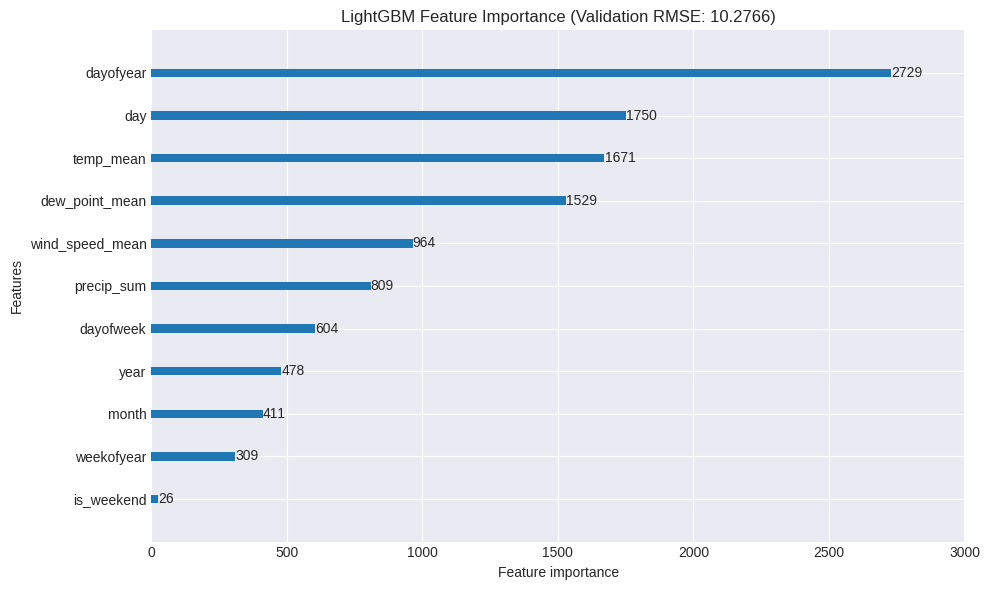

In [11]:
print("Evaluating model on the validation set...")

# Predict on the validation set features
val_preds = model.predict(X_val)

# Optional: Ensure no negative predictions (kWh cannot be negative)
val_preds_non_negative = np.maximum(0, val_preds)
negative_preds_count = np.sum(val_preds < 0)
if negative_preds_count > 0:
    print(f"Warning: {negative_preds_count} negative predictions were clipped to 0.")

# --- Calculate RMSE using the non-negative predictions ---
rmse = math.sqrt(mean_squared_error(y_val, val_preds_non_negative))
print(f"\nValidation RMSE: {rmse:.4f}")

# --- Feature Importance Plot ---
# Plotting helps understand which features the model found most useful
print("\nPlotting feature importance...")
try:
    lgb.plot_importance(model, figsize=(10, max(6, len(features)//2)), max_num_features=len(features))
    plt.title(f'LightGBM Feature Importance (Validation RMSE: {rmse:.4f})')
    plt.tight_layout()
    plt.show()
except Exception as plot_err:
    print(f"Could not plot feature importance: {plot_err}")

# Optional: Analyze Residuals
# residuals = y_val - val_preds_non_negative
# plt.figure(figsize=(10, 6))
# sns.histplot(residuals, bins=50, kde=True)
# plt.title('Distribution of Residuals (Actual - Predicted)')
# plt.xlabel('Error (kWh)')
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(val_preds_non_negative, residuals, alpha=0.5)
# plt.title('Residuals vs. Predicted Values')
# plt.xlabel('Predicted kWh')
# plt.ylabel('Residual (Actual - Predicted)')
# plt.axhline(0, color='red', linestyle='--')
# plt.show()

## 8. Prepare Test Data and Generate Predictions

Now we prepare the actual test dataset based on the `SampleSubmission.csv` file. This involves:
1.  Extracting the required future `date` and `user_id` from the `ID` column in the sample submission.
2.  Merging the relevant aggregated daily `climate` data for those future dates.
3.  Creating the same date-based `features` that the model was trained on.
4.  Handling any potential missing climate data for future dates (e.g., by forward filling the last known values).
5.  Using the trained `model` to predict `daily_kwh` for the test set.

In [12]:
print("Preparing test data for final prediction...")

# --- Create Test Set Structure from Sample Submission ---
if 'ID' not in sample_sub.columns:
    raise KeyError("Column 'ID' not found in SampleSubmission.csv.")

test_df = sample_sub[['ID']].copy()
# Extract date and user_id from the submission ID string
try:
    test_df['date_str'] = test_df['ID'].str.split('_').str[0]
    test_df['date'] = pd.to_datetime(test_df['date_str'], errors='coerce')
    # Reconstruct user_id (everything after the date and the first underscore)
    test_df['user_id'] = test_df['ID'].str.split('_', n=1).str[1]
except Exception as e:
    print(f"Error parsing ID column in sample submission: {e}")
    raise

# Drop rows where date parsing failed, if any
invalid_dates = test_df['date'].isnull().sum()
if invalid_dates > 0:
    print(f"Warning: Removed {invalid_dates} rows from test set due to invalid date format in ID.")
    test_df.dropna(subset=['date'], inplace=True)

print(f"Test set initial structure created. Shape: {test_df.shape}")
print("Test DataFrame Head (with parsed date/user):")
print(test_df.head())

# --- Merge Future Climate Data ---
# Use the aggregated daily climate data prepared earlier
test_df = pd.merge(test_df, daily_climate, on='date', how='left')
print(f"Test set shape after merging climate data: {test_df.shape}")

# --- Handle Missing Climate Data for Future Dates ---
# Important: Future dates might not have climate data in our historical set.
# Sort by date first to ensure correct forward filling
test_df.sort_values(by='date', inplace=True)
# Forward fill using the last known climate values
test_df.fillna(method='ffill', inplace=True)

# Check if any NaNs remain (e.g., if test dates are *before* the first climate date)
remaining_nans = test_df[daily_climate.columns.difference(['date'])].isnull().sum()
if remaining_nans.sum() > 0:
     print(f"\nWarning: NaNs remain in test climate data after forward fill:")
     print(remaining_nans[remaining_nans > 0])
     print("This might happen if test dates are before the start of climate data.")
     print("Filling remaining NaNs with 0 - consider a more robust strategy (e.g., overall mean/median) if this occurs.")
     test_df.fillna(0, inplace=True) # Simple strategy for remaining NaNs

# --- Create Features for Test Set ---
print("\nCreating features for the test set...")
test_df = create_date_features(test_df, 'date')

# --- Align Test Columns with Training Features ---
# Ensure test set has exactly the same feature columns as the training set, in the same order
try:
    X_test = test_df[features]
except KeyError as e:
    print(f"Error aligning test features: Missing column {e}")
    print(f"Columns available in test_df: {test_df.columns.tolist()}")
    print(f"Features expected by model: {features}")
    raise

# Check for NaNs in the final test features (should not happen after fillna steps)
if X_test.isnull().any().any():
    print("\n--- FATAL ERROR: NaNs found in final test features before prediction! ---")
    print(X_test.isnull().sum())
    raise ValueError("NaNs detected in test features. Check data preparation and fillna steps.")
else:
    print("\nTest features successfully prepared and checked for NaNs.")

print(f"Final test data shape for prediction (X_test): {X_test.shape}")
print("Test Data Head (Ready for Prediction):")
print(X_test.head())

# --- Predict on Test Set ---
print("\nPredicting on the prepared test set...")
test_predictions = model.predict(X_test)

# Ensure no negative predictions
test_predictions_non_negative = np.maximum(0, test_predictions)
test_neg_count = np.sum(test_predictions < 0)
if test_neg_count > 0:
    print(f"Note: {test_neg_count} negative predictions in test set were clipped to 0.")

print("Prediction on test set complete.")

Preparing test data for final prediction...
Test set initial structure created. Shape: (6014, 4)
Test DataFrame Head (with parsed date/user):
                                          ID    date_str       date  \
0  2024-09-24_consumer_device_12_data_user_1  2024-09-24 2024-09-24   
1  2024-09-25_consumer_device_12_data_user_1  2024-09-25 2024-09-25   
2  2024-09-26_consumer_device_12_data_user_1  2024-09-26 2024-09-26   
3  2024-09-27_consumer_device_12_data_user_1  2024-09-27 2024-09-27   
4  2024-09-28_consumer_device_12_data_user_1  2024-09-28 2024-09-28   

                          user_id  
0  consumer_device_12_data_user_1  
1  consumer_device_12_data_user_1  
2  consumer_device_12_data_user_1  
3  consumer_device_12_data_user_1  
4  consumer_device_12_data_user_1  
Test set shape after merging climate data: (6014, 8)

Creating features for the test set...

Test features successfully prepared and checked for NaNs.
Final test data shape for prediction (X_test): (6014, 12)
Test D

<ipython-input-12-5cc4e5cfab1e>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df.fillna(method='ffill', inplace=True)


## 9. Generate Submission File

Create the final submission file in the format required by Zindi: a CSV file with two columns, `ID` and `kwh`. The `ID` column must match the `SampleSubmission.csv`.

In [13]:
print("Generating submission file...")

# Create the submission DataFrame
submission_df = pd.DataFrame({'ID': test_df['ID'], 'kwh': test_predictions_non_negative})

# Define the submission filename
submission_filename = 'submission_baseline_lgb_v1.csv' # Increment version number as you improve

# Save the submission file
submission_df.to_csv(submission_filename, index=False)

print("\n--- Submission File Head ---")
print(submission_df.head())
print(f"\nSubmission file saved successfully as: {submission_filename}")
print(f"File shape: {submission_df.shape}")

# Optional: Check if the number of rows matches the sample submission
if len(submission_df) == len(sample_sub):
    print("Number of rows matches SampleSubmission.csv.")
else:
    print(f"Warning: Row count mismatch! Submission has {len(submission_df)} rows, SampleSub has {len(sample_sub)} rows.")

Generating submission file...

--- Submission File Head ---
                                             ID       kwh
0     2024-09-24_consumer_device_12_data_user_1  0.028417
1054  2024-09-24_consumer_device_16_data_user_5  0.028417
2325  2024-09-24_consumer_device_22_data_user_7  0.028417
3224   2024-09-24_consumer_device_2_data_user_1  0.028417
4216  2024-09-24_consumer_device_32_data_user_4  0.028417

Submission file saved successfully as: submission_baseline_lgb_v1.csv
File shape: (6014, 2)
Number of rows matches SampleSubmission.csv.


--- End of Baseline Notebook ---

Next steps:
- Submit the generated CSV to Zindi.
- Analyze the results (local RMSE vs Zindi score).
- Improve the model by:
    - Adding more features (lags, rolling windows, user features).
    - Tuning hyperparameters (e.g., using Optuna).
    - Trying different models (XGBoost, CatBoost).
    - Implementing more robust validation (Time Series Cross-Validation).
    - Ensembling models.